In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt


import torch
from startorch import example as ex
from startorch import transformer as tr
from startorch import timeseries as ts
from startorch import sequence as seq
from startorch import tensor as te
from startorch import transition as tran
from startorch.utils.seed import get_torch_generator

In [3]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (16, 5)

In [4]:
random_seed = 15803713921897248048

# Table of content

## Markov + Exponential
[top](#Table-of-content)

In [5]:
rng = get_torch_generator(random_seed)
num_classes = 10
actions = torch.arange(num_classes)

generator_transition = tran.Normalize(
    generator=tran.MaskedTransitionGenerator(
        generator=tran.TensorTransitionGenerator(te.RandUniform(0.5, 1.0)),
        # generator=tran.TensorTransitionGenerator(te.Full(1.0)),
        num_mask=num_classes - 2,
    ),
    p=1.0,
)
transition = generator_transition.generate(n=num_classes, rng=rng)
print(transition)

weights = torch.logspace(start=0.1, end=1.0, steps=num_classes)

generator = ex.Transform(
    generator=ex.TimeSeriesExampleGenerator(
        generators=ts.SequenceTimeSeriesGenerator(
            # generators={"action": seq.RandInt(0, num_classes)},
            generators={"action": seq.MarkovChain(transition=transition)},
        ),
        seq_len=te.Full(128),
    ),
    transformer=tr.Sequential(
        [
            tr.LookupTable(weights=weights, index="action", output="rate"),
            tr.Exponential(rate="rate", output="time")
        ]
    ),
)
print(generator)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.4333, 0.0000, 0.0000, 0.5667, 0.0000,
         0.0000],
        [0.5200, 0.0000, 0.4800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4753, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5247,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4716, 0.0000, 0.5284, 0.0000,
         0.0000],
        [0.0000, 0.5356, 0.0000, 0.4644, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4225],
        [0.0000, 0.0000, 0.3607, 0.0000, 0.0000, 0.0000, 0.6393, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.4542, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5458,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4058, 0.5942, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4604, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5396]])
Transform

In [6]:
batch = generator.generate(batch_size=10000, rng=rng)

for key, value in batch.items():
    print(key, tuple(value.shape))

action = batch["action"].numpy().ravel()
time = batch["time"].numpy().ravel()

action (10000, 128)
rate (10000, 128)
time (10000, 128)


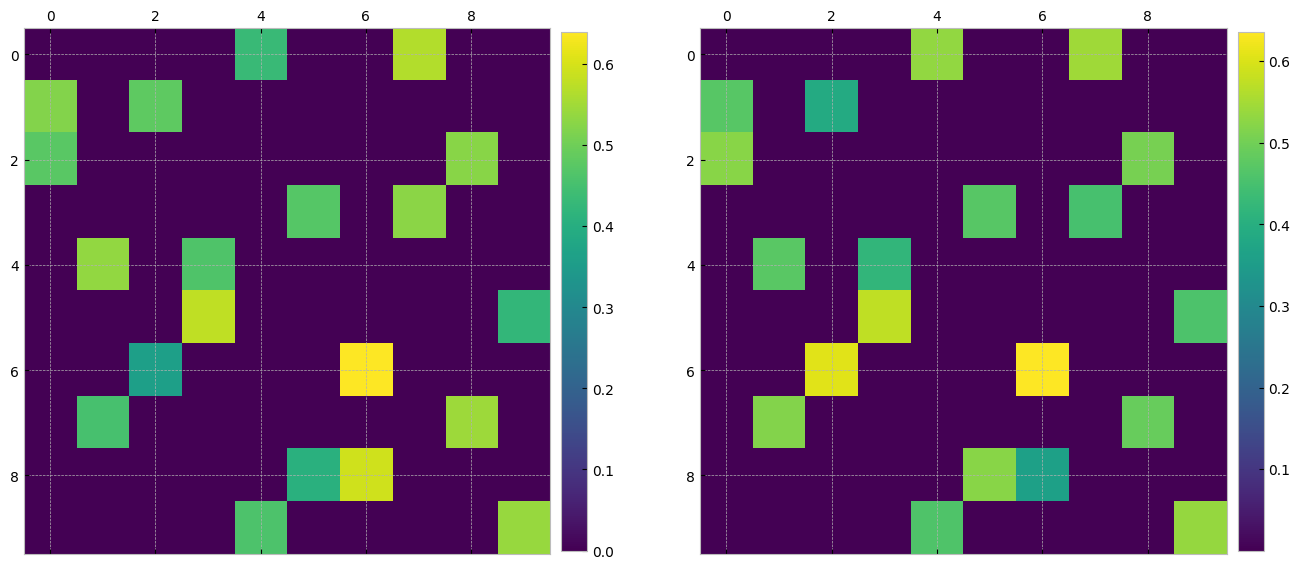

In [11]:
# Analyze the action distribution
action_transition = torch.zeros(num_classes, num_classes)
for i, j in zip(action[:-1], action[1:], strict=True):
    action_transition[i, j] += 1
action_transition = action_transition / action_transition.sum(dim=1)
fig, axes = plt.subplots(figsize=(16, 8), ncols=2)
t0 = axes[0].matshow(transition)
t1 = axes[1].matshow(action_transition)
_ = fig.colorbar(t0, ax=axes[0], fraction=0.046, pad=0.02)
_ = fig.colorbar(t1, ax=axes[1], fraction=0.046, pad=0.02)

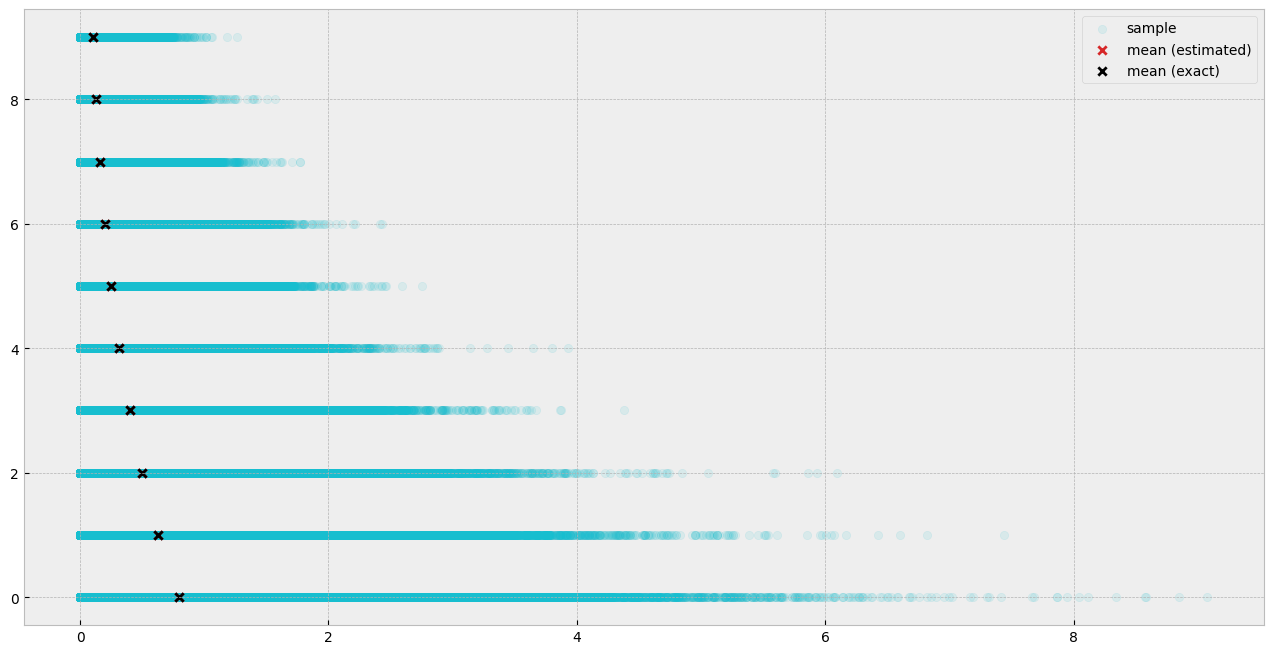

In [8]:
# Analyze the time distribution
fig, ax = plt.subplots(figsize=(16, 8))
_ = ax.scatter(time, action, alpha=0.1, color="tab:cyan", label="sample")
_ = ax.scatter([time[action == i].mean().item() for i in range(num_classes)], actions, color="tab:red", label="mean (estimated)", marker="x")
_ = ax.scatter((1 / weights).numpy(), actions.numpy(), color="black", label="mean (exact)", marker="x")
_ = ax.legend()